In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib

import os
# This line will supress the TF output 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

## Model testing with MIDAP

This notebook can be used to test models. It calculates the accuracy of the model for a test set and makes some plots. 

In [2]:
#########################
# define the parameters #
#########################


# Choose a model to test
custom_model = None # Use the standard UNet
# custom_model = "CustomUNet" # Use a model defined in ../custom_model.py

# The path were the weights should be restored from
restore_path = "../../model_weights/model_weights_family_mother_machine/model_weights_ZF270g.h5"

# The data for the testing
test_data = "../training_data/ZF270g/test/testing_data_ZF270g_1.npz"

In [3]:
# load the data 
###############

data = np.load(test_data)
X_test = data['X_test']
y_test = data['y_test']
weight_maps_test = data['weight_maps_test']

In [4]:
# Load the model
################

if custom_model is None:
    # load the standard UNet
    from midap.networks.unets import UNetv1 as ModelClass
else:
    # Load the class that was defined above
    spec = importlib.util.spec_from_file_location("module", "../custom_model.py")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    ModelClass = getattr(module, "CustomUNet")
    
# initialize the model
model = ModelClass(input_size=X_test.shape[1:], dropout=0.5)

# restore the weights
model.load_weights(restore_path)

In [5]:
# Test the model
evaluation = model.evaluate(x=[X_test,
                               weight_maps_test,
                               y_test],
                            y=y_test,
                            batch_size=8)

338/338 [==============================] - 69s 191ms/step - loss: 0.0245 - accuracy: 0.9946


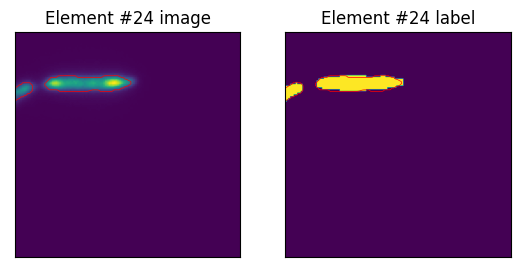

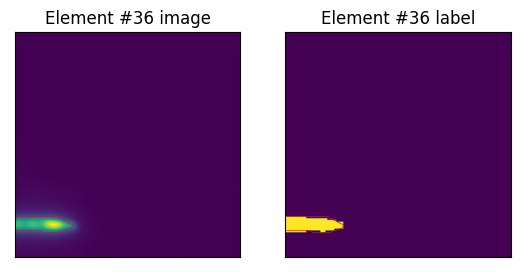

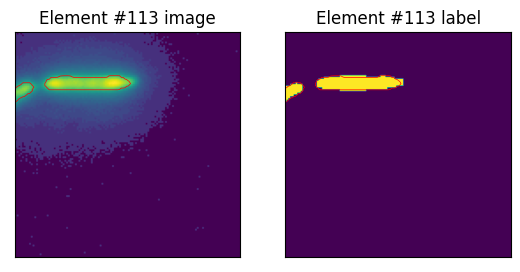

In [6]:
# plot overlays
###############

# slect the indices of the test set to plot
indices_to_plot = [24, 36, 113]

for index in indices_to_plot:
    # eval the model
    sample, w, l = X_test[index], weight_maps_test[index], y_test[index]
    pred = model.predict([sample[None,...], w[None,...], l[None,...]], verbose=0)[0,...,0]
    
    # create the plot
    fig, axes = plt.subplots(1,2)
    
    # overlay with original image
    axes[0].set_title(f"Element #{index} image")
    axes[0].imshow(sample)
    axes[0].contour(pred, [0.5], colors='r', linewidths=0.5)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    # overlay with label
    axes[1].set_title(f"Element #{index} label")
    axes[1].imshow(l)
    axes[1].contour(pred, [0.5], colors='r', linewidths=0.5)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.show()